# This notebook can be used to generate data for UNet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from copy import deepcopy
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from typing import Tuple, Union, List, Any
from tqdm import tqdm
import sys
from pickle import dump, load

In [3]:
from biomedical_image_segmentation.elastic_deform import custom_2d_elastic_deform
from biomedical_image_segmentation.utils import insert_grid, split
from biomedical_image_segmentation.data.generator import generate
from biomedical_image_segmentation.data.validator import validate

In [4]:
PROJECT_PATH = os.getcwd().replace("notebooks","")
DATA_PATH = os.path.join(PROJECT_PATH, "data")
SAMPLES_PATH = os.path.join(DATA_PATH, "samples")
TRAIN_SAMPLES_PATH = os.path.join(SAMPLES_PATH, "train")
TEST_SAMPLES_PATH = os.path.join(SAMPLES_PATH, "test")
MASKS_PATH = os.path.join(DATA_PATH, "masks")
TRAIN_MASKS_PATH = os.path.join(MASKS_PATH, "train")
TEST_MASKS_PATH = os.path.join(MASKS_PATH, "test")
AUGMENTED_DATA_PATH = os.path.join(DATA_PATH, "augmented")


try: 
    os.mkdir(AUGMENTED_DATA_PATH) 
except OSError as error: 
    print(error)  

if os.path.isdir(AUGMENTED_DATA_PATH):
    for f in tqdm(os.listdir(AUGMENTED_DATA_PATH), leave=False):
        try:
            os.remove(os.path.join(AUGMENTED_DATA_PATH, f))
        except Exception as e:
            print(e)
    
ALPHA_AFFINE = (.01, .2)
SIGMA = 10.
ALPHA = 1.
ADJUSTMENT_PIXEL_RANGE = (5, 100)
ADJUSTED_PIXEL = 0

[WinError 183] Cannot create a file when that file already exists: 'E:\\Projects\\biomedical_image_segmentation\\data\\augmented'


In [5]:
img_name = np.random.choice(os.listdir(TRAIN_SAMPLES_PATH))
img_path = os.path.join(TRAIN_SAMPLES_PATH, img_name)
mask_path = os.path.join(TRAIN_MASKS_PATH, img_name)

In [6]:
img =  cv2.imread(img_path)
mask = cv2.imread(mask_path)
print(f"Image shape: {img.shape}, mask shape: {mask.shape}")

Image shape: (512, 512, 3), mask shape: (512, 512, 3)


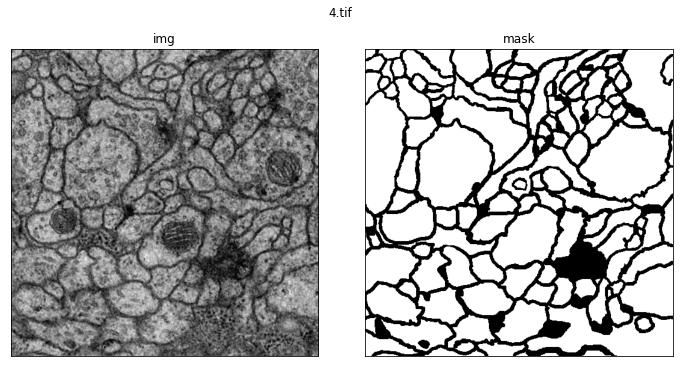

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(img, cmap="gray")
ax1.set_title("img")
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax2.imshow(mask, cmap="gray")
ax2.set_title("mask")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
fig.suptitle(t=img_name, x=.5, y=1.)
plt.tight_layout()
plt.show()

In [8]:
%%time
dataset = generate(
    img[:,:,0],
    mask[:,:,0],
    num_elastic_deforms=1,
    alpha_affine=ALPHA_AFFINE,
    sigma=SIGMA,
    alpha=ALPHA,
    adjustment_pixel_range=ADJUSTMENT_PIXEL_RANGE, 
    adjusted_pixel=ADJUSTED_PIXEL )

Wall time: 4.38 s


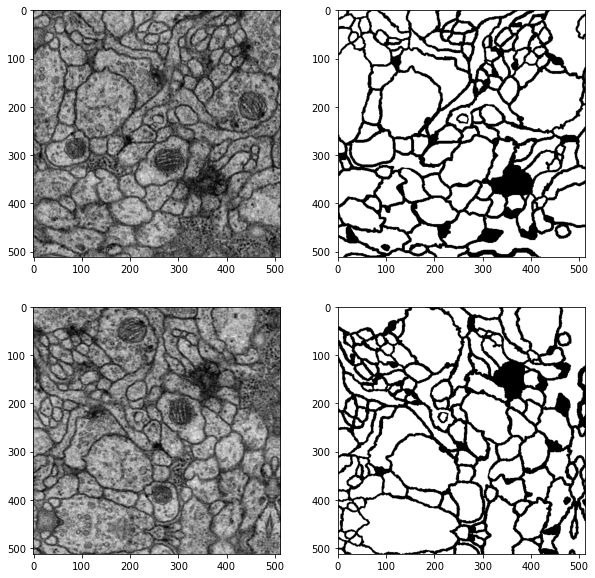

In [9]:
i = np.random.choice(len(dataset))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0,0].imshow(img, cmap="gray")
axes[0,1].imshow(mask, cmap="gray")
axes[1,0].imshow(dataset[i][0], cmap="gray")
axes[1,1].imshow(dataset[i][1], cmap="gray")
plt.show()

In [10]:
validate(dataset, shape=(512, 512), check_for_duplicates=True)

In [11]:
%%time
sys.getsizeof([np.random.choice((0, 255), size=(512, 512)) for i in range(100)]) * 2 / (1024 * 1024)

Wall time: 323 ms


0.0017547607421875

In [12]:
train_ids, valid_ids, test_ids = split(os.listdir(TRAIN_SAMPLES_PATH)) 

In [ ]:
validation = True
threshold_validation = .5

for i, train_id in tqdm(enumerate(train_ids), leave=False):
    
    img =  cv2.imread(os.path.join(TRAIN_SAMPLES_PATH, train_id))
    mask = cv2.imread(os.path.join(TRAIN_MASKS_PATH, train_id))
    
    dataset = generate(
        img[:,:,0],
        mask[:,:,0],
        num_elastic_deforms=10,
        alpha_affine=ALPHA_AFFINE,
        sigma=SIGMA,
        alpha=ALPHA,
        adjustment_pixel_range=ADJUSTMENT_PIXEL_RANGE, 
        adjusted_pixel=ADJUSTED_PIXEL)
    
    if (validation and np.random.uniform() > threshold_validation): validate(dataset)
        
    with open(f"{os.path.join(AUGMENTED_DATA_PATH, train_id.replace('.tif',''))}.pickle", "wb") as f:
        dump(dataset, f)
    
    del dataset

12it [08:59, 46.35s/it]

In [ ]:
with open(f"{os.path.join(AUGMENTED_DATA_PATH, np.random.choice(os.listdir(AUGMENTED_DATA_PATH)))}", 'rb') as f:
    dataset = load(f)
    
i = np.random.choice(len(dataset))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0,0].imshow(img, cmap="gray")
axes[0,1].imshow(mask, cmap="gray")
axes[1,0].imshow(dataset[i][0], cmap="gray")
axes[1,1].imshow(dataset[i][1], cmap="gray")
plt.show()